# Inference

In [65]:
from torch.utils.data import DataLoader # type: ignore
import torch.optim as optim # type: ignore
from torch.optim.lr_scheduler import ReduceLROnPlateau # type: ignore
from torch import nn # type: ignore

from hython.models.cudnnLSTM import CuDNNLSTM
from hython.datasets.datasets import get_dataset
from hython.sampler import *
from hython.normalizer import Normalizer
from hython.trainer import *
from hython.utils import read_from_zarr, missing_location_idx, set_seed, prepare_for_plotting
from hython.evaluator import predict
from hython.trainer import train_val

import matplotlib.pyplot as plt
from hython.viz import map_kge, map_bias, map_pbias, map_pearson, map_rmse, map_at_timesteps, ts_compare, plot_sampler, compute_kge_parallel, ts_plot, map_points

# Settings

In [66]:
## inputs

# wflow model name, i.e. surrogate input file produced by the preprocessing application

surr_input = "datademo.zarr"

surr_model =  "demo.pt"
experiment = "exp1"

dir_wflow_model = "datademo"
file_target =  "output.nc"



# input directory 
dir_surr_input = "../data/datademo"
dir_surr_model = "../data/datademo"
dir_wflow_input = "../data"

dynamic_names = ["precip", "pet", "temp"] 
static_names = [ 'thetaS', 'thetaR', 'RootingDepth', 'Swood','KsatVer', "Sl"] 
target_names = [ "vwc","actevap"] 

# DL model hyper parameters
HIDDEN_SIZE = 24
DYNAMIC_INPUT_SIZE = len(dynamic_names)
STATIC_INPUT_SIZE = len(static_names)
OUTPUT_SIZE = len(target_names)
TARGET_WEIGHTS = {t:0.5 for t in target_names}

# train/val parameters

train_temporal_range = slice("2016-01-01","2018-12-31")
valid_temporal_range = slice("2020-01-01", "2021-12-31")

EPOCHS = 20
BATCH = 256
TEMPORAL_SUBSAMPLING = True
TEMPORAL_SUBSET = 150 
SEQ_LENGTH = 120

mask_names = ["mask_missing"]


metrics = {
  "vwc": ["rmse", "kge", "corr", "pbias"],
  "actevap": ["rmse", "kge", "corr", "pbias"]
}
assert sum(v for v in TARGET_WEIGHTS.values()) == 1, "check target weights"
TARGET_INITIALS = "".join([i[0].capitalize() for i in target_names])

# paths

file_surr_input = f"{dir_surr_input}/{surr_input}"

file_surr_model = f"{dir_surr_model}/{experiment}_{surr_model}"

file_wflow_target = f"{dir_wflow_input}/{dir_wflow_model}/{file_target}"


In [67]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [68]:
Xd = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Xs = read_from_zarr(url=file_surr_input, group="xs", multi_index="gridcell").xs.sel(
    feat=static_names
)
Y = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=train_temporal_range)
    .y.sel(feat=target_names)
)

# === READ VALID. ============================================================= 

Xd_valid = (
    read_from_zarr(url=file_surr_input, group="xd", multi_index="gridcell")
    .sel(time=valid_temporal_range)
    .xd.sel(feat=dynamic_names)
)
Y_valid = (
    read_from_zarr(url=file_surr_input, group="y", multi_index="gridcell")
    .sel(time=valid_temporal_range)
    .y.sel(feat=target_names)
)

SHAPE = Xd.attrs["shape"]
TIME_RANGE = Xd.shape[1]

# MASK
masks = (
    read_from_zarr(url=file_surr_input, group="mask")
    .mask.sel(mask_layer=mask_names)
    .any(dim="mask_layer")
)

In [69]:
normalizer_dynamic = Normalizer(method="standardize", type="spacetime")

normalizer_static = Normalizer(method="standardize", type="space")

normalizer_target = Normalizer(method="standardize", type="spacetime")


normalizer_dynamic.compute_stats(Xd)
normalizer_static.compute_stats(Xs)
normalizer_target.compute_stats(Y)

# TODO: save stats, implement caching of stats to save computation

Xd_valid = normalizer_dynamic.normalize(Xd_valid)
Xs = normalizer_static.normalize(Xs)
Y_valid = normalizer_target.normalize(Y_valid)

In [70]:
model = CuDNNLSTM(hidden_size=HIDDEN_SIZE, 
                  dynamic_input_size=DYNAMIC_INPUT_SIZE,
                  static_input_size=STATIC_INPUT_SIZE, 
                  output_size=OUTPUT_SIZE)

In [71]:
model.to(device)
opt = optim.Adam(model.parameters(), lr=1e-3)
lr_scheduler = ReduceLROnPlateau(opt, mode="min", factor=0.5, patience=10)

# model load precomputed weights 
model.load_state_dict(torch.load(file_surr_model))

<All keys matched successfully>

# Inference 

In [72]:
ds_target = xr.open_dataset(file_wflow_target, chunks= {"time":200}).isel(lat=slice(None, None, -1))#.sel(layer=1, drop=True)

lat, lon, time = len(masks.lat),len(masks.lon), Xd_valid.shape[1]

y_pred = predict(Xd_valid.values, Xs.values, model, BATCH, device)

y_pred = normalizer_target.denormalize(y_pred)



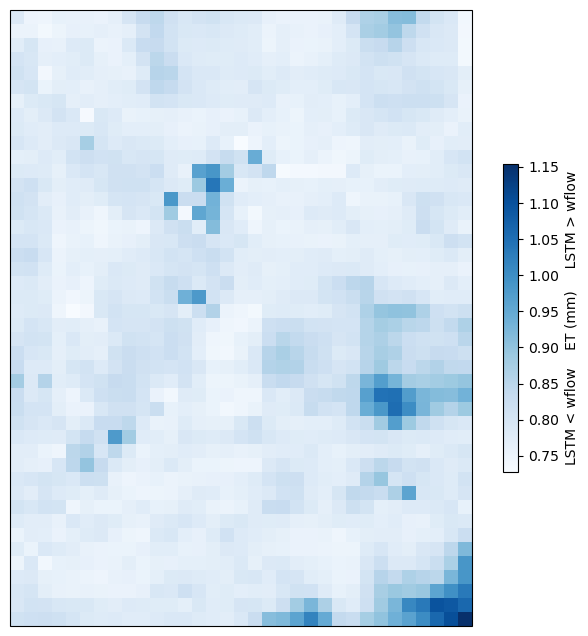

In [82]:
y_target_plot, y_pred_plot = prepare_for_plotting(y_target=Y_valid[:,:,[1]].values,
                                              y_pred = y_pred[:,:,[1]], 
                                              shape = (lat, lon, time), 
                                              coords  = ds_target.sel(time=valid_temporal_range).coords)


y_target_plot= y_target_plot.where(~masks.values[...,None])
y_pred_plot = y_pred_plot.where(~masks.values[...,None])

eval_var = target_names[0]
metric = metrics.get(eval_var)[0]

fig, ax, rmse = map_rmse(y_target_plot, y_pred_plot, unit = "ET (mm)", figsize = (8, 8), return_rmse=True)

### RMSE

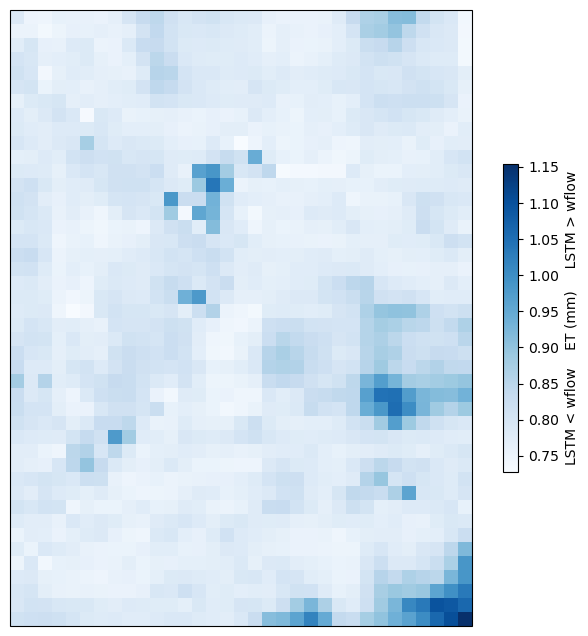

In [83]:
et_rmse = map_rmse(y_target_plot, y_pred_plot, unit = "ET (mm)", figsize = (8, 8), return_rmse=True)

### PBIAS

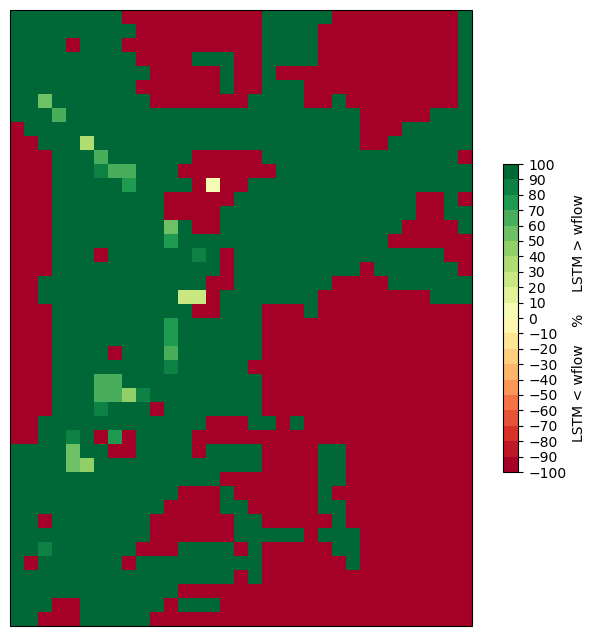

In [84]:
et_pbias = map_pbias(y_target_plot, y_pred_plot, figsize = (8, 8), kwargs_imshow={"vmin":-100, "vmax":100}, 
                    ticks = [l*10 for l in range(-10,11, 1)], return_pbias=True)

### KGE

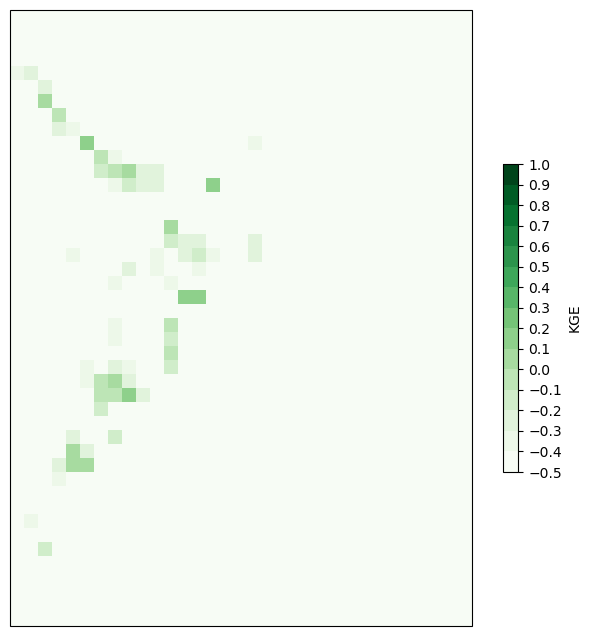

In [85]:
et_kge = map_kge(y_target_plot, y_pred_plot, figsize = (8, 8), return_kge =True, kwargs_imshow={"vmin":-0.5, "vmax":1},
                ticks = np.linspace(-0.5, 1, 16))

# Soil Moisture

### RMSE

In [86]:
y_target_plot, y_pred_plot = prepare_for_plotting(y_target=Y_valid[:,:,[0]].values,
                                              y_pred = y_pred[:,:,[0]], 
                                              shape = (lat, lon, time), 
                                              coords  = ds_target.sel(time=valid_temporal_range).coords)


y_target_plot= y_target_plot.where(~masks.values[...,None])
y_pred_plot = y_pred_plot.where(~masks.values[...,None])

eval_var = target_names[0]
metric = metrics.get(eval_var)[0]

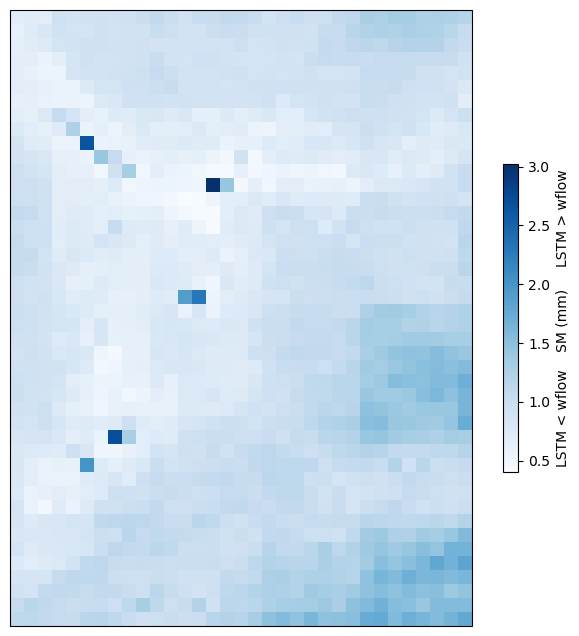

In [87]:
sm_rmse = map_rmse(y_target_plot, y_pred_plot, unit = "SM (mm)", figsize = (8, 8), return_rmse=True)

### PBIAS

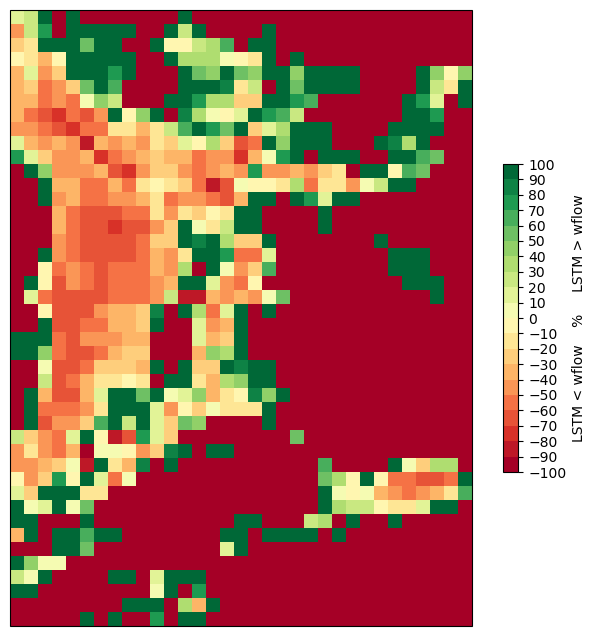

In [88]:
sm_pbias = map_pbias(y_target_plot, y_pred_plot, figsize = (8, 8), return_pbias=True, kwargs_imshow={"vmin":-100, "vmax":100}, 
                    ticks = [l*10 for l in range(-10,11, 1)])

### KGE

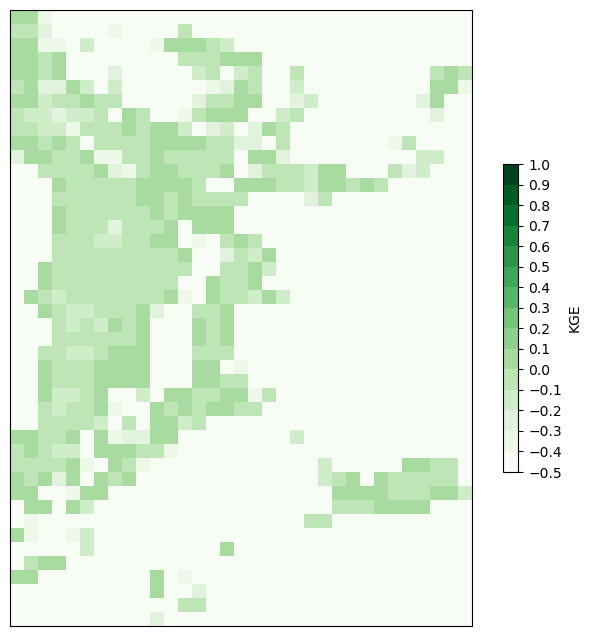

In [89]:
sm_kge = map_kge(y_target_plot, y_pred_plot, figsize = (8, 8), return_kge =True, kwargs_imshow={"vmin":-0.5, "vmax":1},
                ticks = np.linspace(-0.5, 1, 16))

In [90]:
out = list(map(lambda x: float(x.mean()),[ sm_pbias, et_pbias, sm_kge, et_kge, sm_rmse, et_rmse] ) )

AttributeError: 'tuple' object has no attribute 'mean'

In [72]:
print( "PBIAS: ", "SM: ", out[0], "ET: ", out[1])
print( "KGE: ", "SM: ", out[2], "ET: ", out[3])
print( "RMSE: ", "SM: ", out[4], "ET: ", out[5])

PBIAS:  SM:  -0.5597563982009888 ET:  1.3485767841339111
KGE:  SM:  0.836525382452951 ET:  0.903612509334448
RMSE:  SM:  0.20723728835582733 ET:  0.09810595214366913
